In [1]:
from sklearn import model_selection
import xgboost as xgb
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
import random

In [100]:
KAGGLE = False

if not KAGGLE:
    train_path = "train.csv"
    test_path = "test.csv"
    train_calendar_path = "train_calendar.csv"
    test_calendar_path = "test_calendar.csv"
    solution_example_path = "solution_example.csv"
else:
    train_path = "/kaggle/input/rohlik-orders-forecasting-challenge/train.csv"
    test_path = "/kaggle/input/rohlik-orders-forecasting-challenge/test.csv"
    train_calendar_path = "/kaggle/input/rohlik-orders-forecasting-challenge/train_calendar.csv"
    test_calendar_path = "/kaggle/input/rohlik-orders-forecasting-challenge/test_calendar.csv"
    solution_example_path = "/kaggle/input/rohlik-orders-forecasting-challenge/solution_example.csv"

In [101]:
train = pd.read_csv(train_path)
train.head(3)

,warehouse,date,orders,holiday_name,holiday,shutdown,mini_shutdown,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,user_activity_1,user_activity_2,id
0,Prague_1,2020-12-05,6895.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1722.0,32575.0,Prague_1_2020-12-05
1,Prague_1,2020-12-06,6584.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1688.0,32507.0,Prague_1_2020-12-06
2,Prague_1,2020-12-07,7030.0,NaN,0,0,0,0,0,0,0,0.0,0,0.0,0.0,1696.0,32552.0,Prague_1_2020-12-07


In [103]:
example = pd.read_csv(solution_example_path)
example.head()

,id,orders
0,Prague_1_2024-03-16,5000
1,Prague_1_2024-03-17,5000
2,Prague_1_2024-03-18,5000
3,Prague_1_2024-03-19,5000
4,Prague_1_2024-03-20,5000


In [104]:
train_calendar = pd.read_csv(train_calendar_path)
train_calendar.sample(5)

,date,holiday_name,holiday,shutdown,mini_shutdown,warehouse_limited,shops_closed,winter_school_holidays,school_holidays,blackout,mov_change,frankfurt_shutdown,precipitation,snow,warehouse
8707,2019-07-23,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Munich_1
1495,2021-01-12,NaN,0,0,0,0,0,0,0,0,0.0,0,39.90,4.0,Prague_1
11366,2023-10-28,NaN,0,0,0,0,0,0,1,0,0.0,0,3.83,0.0,Frankfurt_1
9211,2019-05-07,NaN,0,0,0,0,0,0,0,0,0.0,0,0.00,0.0,Munich_1
5045,2021-10-11,NaN,0,0,0,0,0,0,0,0,0.0,0,0.60,0.0,Prague_2


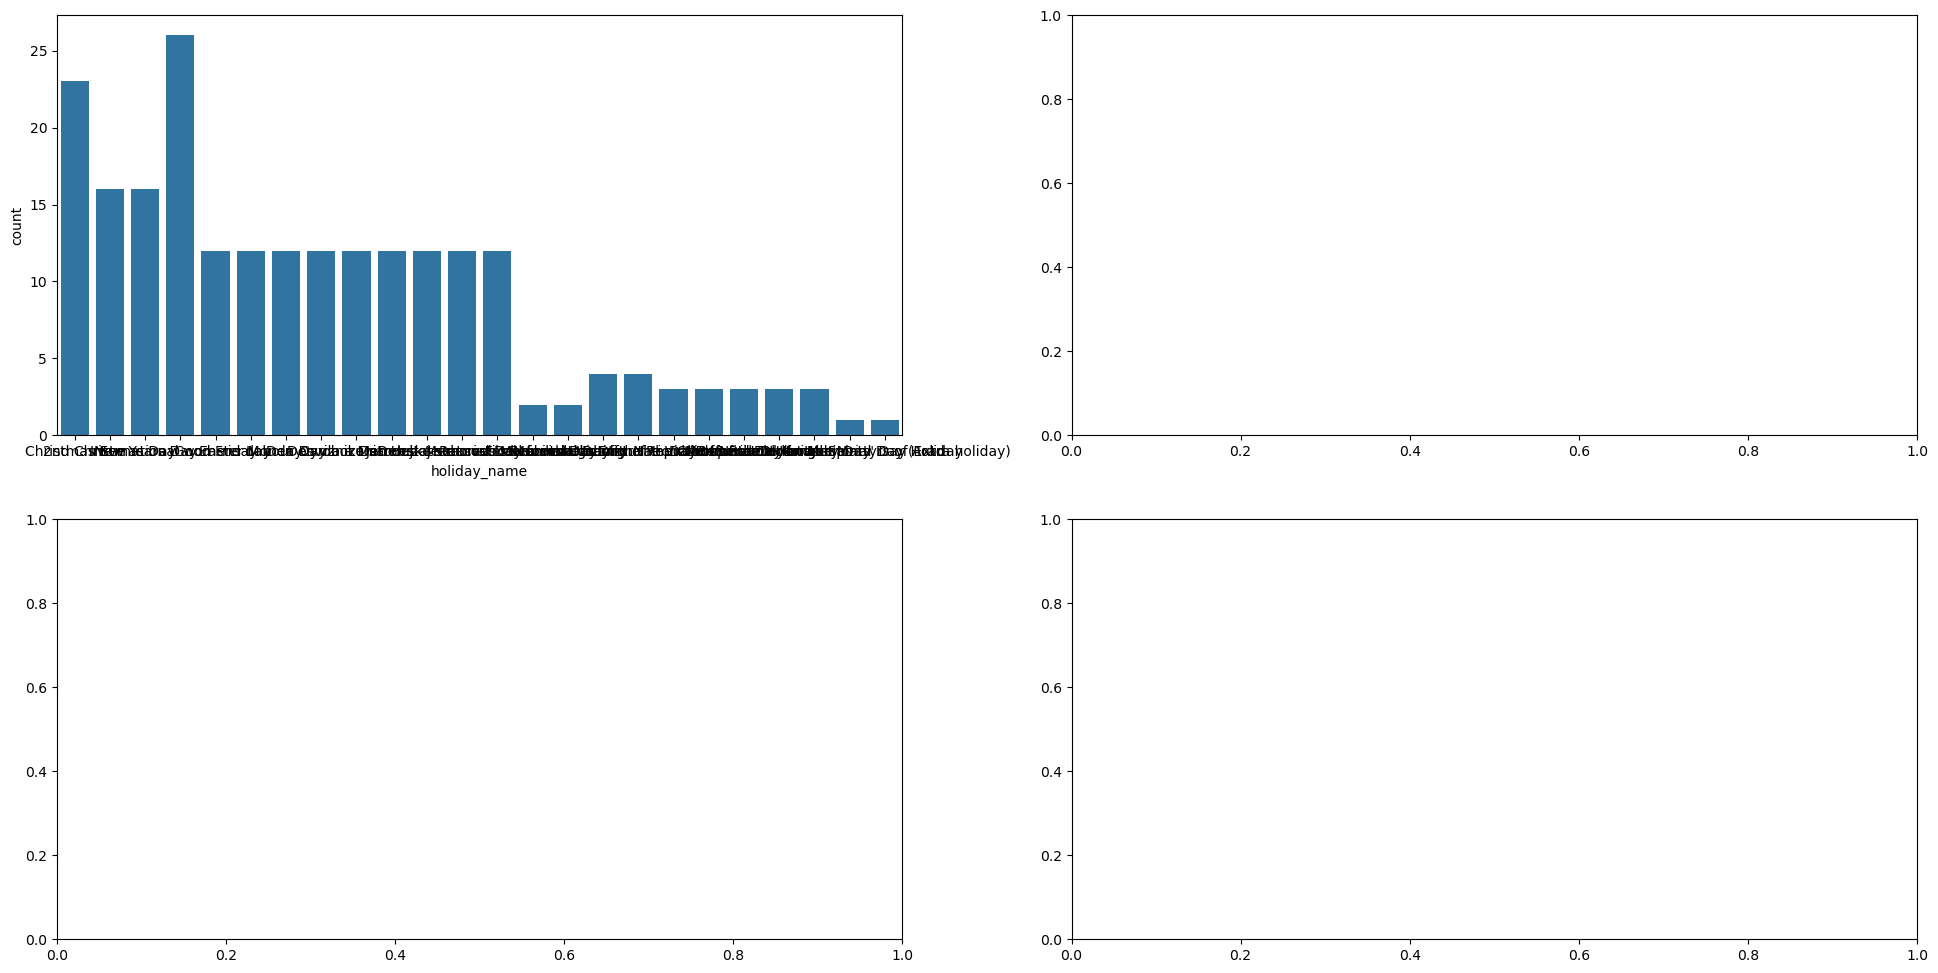

In [105]:
def plot_data(metadata):
    fig, axes = plt.subplots(2, 2, figsize=(24, 12))
    sns.countplot(data=metadata, x="holiday_name", ax=axes[0][0])

plot_data(metadata=train)

In [106]:
train.isna()["holiday_name"].sum()

7122

In [110]:

# use same mappings for both train and inference
#use cat boost, ada boost, xgboost, lgbm

holiday_map = {k: v-1 for v, k in enumerate(train["holiday_name"].unique())}
for key in holiday_map:
    if isinstance(key, float) and np.isnan(key):
        holiday_map[-1] = holiday_map.pop(key)
        break

warehouse_map = {k: v for v, k in enumerate(train["warehouse"].unique())}
def clear_data(metadata, test_metadata, test: bool = False):
    new_df = metadata.copy()
    common_columns = new_df.columns.intersection(test_metadata.columns)
    print(common_columns)
    if not test:
        uncommon_columns = new_df.drop(columns=common_columns).columns[1:] # keep orders
    else:
        uncommon_columns = new_df.drop(columns=common_columns).columns


    new_df = new_df.drop(columns=uncommon_columns)
    new_df = new_df.drop(columns=["id"])
    new_df.fillna({"holiday_name": -1}, inplace=True)
    new_df["holiday_name"] = new_df["holiday_name"].map(holiday_map)
    new_df["warehouse"] = new_df["warehouse"].map(warehouse_map)

    #week_day = new_df["date"].dt.dayofweek
    new_df["date"] = pd.to_datetime(new_df["date"])
    new_df["day_of_week"] = new_df["date"].dt.dayofweek
    new_df["day_of_year"] = new_df["date"].dt.dayofyear
    new_df["day_of_month"] = new_df["date"].dt.day
    new_df["month"] = new_df["date"].dt.month
    new_df["year"] = new_df["date"].dt.year

    new_df.drop(columns=["date"], inplace=True)
    return new_df


In [111]:
test_metadata = pd.read_csv("test.csv")
clear_train = clear_data(metadata=train, test_metadata=test_metadata)
clear_test = clear_data(metadata=test_metadata, test_metadata=test_metadata, test=True)
print(clear_test.head(2))
clear_train.sample(90)

Index(['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
Index(['warehouse', 'date', 'holiday_name', 'holiday', 'shops_closed',
       'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
   warehouse  holiday_name  holiday  shops_closed  winter_school_holidays  \
0          0            -1        0             0                       0   
1          0            -1        0             0                       0   

   school_holidays  day_of_week  day_of_year  day_of_month  month  year  
0                0            5           76            16      3  2024  
1                0            6           77            17      3  2024  


,warehouse,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,day_of_week,day_of_year,day_of_month,month,year
6322,6,4890.0,-1,0,0,0,0,1,117,27,4,2021
3583,3,4063.0,-1,0,0,0,0,2,344,9,12,2020
6724,6,4949.0,20,0,0,0,0,6,170,19,6,2022
6482,6,5472.0,-1,0,0,0,0,4,281,8,10,2021
6827,6,5299.0,-1,0,0,0,0,5,274,1,10,2022
...,...,...,...,...,...,...,...,...,...,...,...,...
4109,3,4339.0,-1,0,0,0,0,5,141,21,5,2022
3856,3,3401.0,-1,0,0,0,0,3,252,9,9,2021
3023,2,4946.0,-1,0,0,0,0,0,248,5,9,2022
832,0,8977.0,-1,0,0,0,0,0,79,20,3,2023


In [112]:
#scaler = StandardScaler()
#scaler = OneHotEncoder()

In [113]:
train_dataset, eval_dataset = train_test_split(clear_train, test_size=0.2, shuffle=True)

In [114]:
#train_inputs = scaler.fit_transform(train_dataset.drop(columns=["orders"]))
train_inputs = train_dataset.drop(columns=["orders"])
train_targets = train_dataset["orders"]
train_inputs.shape

(5872, 11)

In [115]:
#eval_inputs = scaler.fit_transform(eval_dataset.drop(columns=["orders"]))
eval_inputs = eval_dataset.drop(columns=["orders"])
eval_targets = eval_dataset["orders"]
eval_inputs.shape

(1468, 11)

In [116]:
class Ensembler:
    def __init__(self, train_data, search):
        self.models_info = {
            "models": [],
            "models_acc": [],
            "ensembler_acc": []
        }

        self.train_dataset, self.eval_dataset = train_test_split(train_data, test_size=0.1, shuffle=True)
        self.search = search


    def xgb_finder(self):
        models = []
        models_acc = []

        random_states = [random.randint(0, 10000000) for _ in range(100)]

        for random_state in random_states:
            xgb_model = xgb.XGBRegressor(random_state=random_state)
            xgb_model.fit(self.train_dataset.drop(columns=["orders"]), self.train_dataset["orders"])
            models.append(xgb_model)

            acc = xgb_model.score(self.eval_dataset.drop(columns=["orders"]), self.eval_dataset["orders"])
            models_acc.append(acc)
        
        best_model = models[models_acc.index(max(models_acc))]
        self.models_info["models"].append(best_model)
        self.models_info["models_acc"].append(max(models_acc))

In [117]:
#models = generate_model(n_models=1000)
ensembler = Ensembler(train_data=clear_train, search=None)

In [118]:
ensembler.xgb_finder()

In [ ]:
best_model = ensembler.models_info["models"][0]
print(ensembler.models_info["models_acc"][0])
best_model.get_params()

0.9875501526614222


{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 8860458,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 9990,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
preds = best_model.predict(clear_test)
print(preds.shape)
preds = np.round(preds).astype(np.int64)

(397,)


In [94]:
df = {
    "id": test_metadata["id"],
    "orders": preds
}

pd.DataFrame(df).to_csv("./submission.csv", index=False)